In [1]:
import QPIXL.helper as hlp
from QPIXL.qiskit.qpixl import cFRQI
from QPIXL.qiskit.qpixl_angs import cFRQIangs, decodeAngQPIXL
import qiskit
from qiskit import QuantumCircuit
from qiskit_aer import StatevectorSimulator
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from PIL import Image
from ipywidgets import interact
import os
from itertools import chain

import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image


warnings.filterwarnings("ignore")

backend = StatevectorSimulator(method="statevector")

# Quantum:Impossible 
## Tom Cruise vs QFT

Initial state:

$$|\text{Image}>_{0,n}$$

We do a transformation in the Fourier space with the QFT applied only in $k\leq n$
$$ QFT_{0,k}^{-1} RZ_{1,k} RY_{1,k} QFT_{0,k} |\text{Image}>_{0,n} $$

if $k = 0$, the image is unchanged:
$$ QFT_{0,k}^{-1} QFT_{0,k} |\text{Image}>_{0,n} =  |\text{Image}>_{0,n}  $$

## QFT Circuit

In [2]:

def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [3]:

def qft_rotations_inverse(circuit, num):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    n = 0
    if n == num:
        return circuit
    
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    n += 1
    qft_rotations_inverse(circuit, n)

def swap_registers_inverse(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft_inverse(circuit, num):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, num)
    swap_registers(circuit, num)
    return circuit

In [4]:
def get_rgb_channels(image_path, target_shape=(82, 82)):
    """
    Loads an image, resizes it, and extracts its Red, Green, and Blue channels.

    Args:
        image_path (str): The path to the input image file (e.g., "figures/tom_cruise.jpg").
        target_shape (tuple): A tuple (height, width) for resizing the image.
                              Defaults to (82, 82).

    Returns:
        list: A list containing three 2D NumPy arrays: [red_channel, green_channel, blue_channel].
              Each channel array has the shape of `target_shape`.
        numpy.ndarray: The original image data as a NumPy array after resizing,
                       useful for determining `Image_data` in your main code.
    """
    try:
        # Open the image
        Image_ = Image.open(image_path)

        # Resize the image to the target shape using LANCZOS resampling for quality
        Image_ = Image_.resize(target_shape, Image.Resampling.LANCZOS)

        # Convert the PIL Image object to a NumPy array
        # This will be a (height, width, 3) array for an RGB image
        Image_data = np.asarray(Image_)

        # Extract channels directly using NumPy slicing 
        # Each slice creates a new 2D array for the respective channel
        red_channel = Image_data[:, :, 0]   # All rows, all columns, 0th (Red) channel
        green_channel = Image_data[:, :, 1] # All rows, all columns, 1st (Green) channel
        blue_channel = Image_data[:, :, 2]  # All rows, all columns, 2nd (Blue) channel

        # Return the channels as a list and the Image_ghost_data (for your main function)
        return [red_channel, green_channel, blue_channel], Image_data

    except FileNotFoundError:
        print(f"Error: The image file '{image_path}' was not found.")
        return None, None

## Interactive results

In [5]:
chans_tom, image_data_tom = get_rgb_channels("figures/tom_cruise.jpg", target_shape=(82, 82))

In [ ]:
def plot_interactive_rot(num_qubits, ang2_ry, ang3_rz, compress):
    encoded_decoded = []
    for i in chans_tom :

        tempi = hlp.pad_0(i.T.flatten())
        maxval = np.max(tempi)
        minval = np.min(tempi)
        qc = cFRQI(tempi, compress)

        qubits = int(num_qubits)
        qft(qc, qubits)

        if qubits ==0:
            qft_inverse(qc, qubits)
        else:
            qc.ry(ang2_ry, range(qubits))
            qc.rz(ang3_rz, range(qubits))
            qft_inverse(qc, qubits)

    
        job = backend.run(qc)

        sv = np.real(job.result().get_statevector())
        img2 = hlp.decodeQPIXL(sv, minval, maxval, scaling=hlp.convertToGrayscaleOld)
        encoded_decoded.append(
            hlp.reconstruct_img(img2, (len(image_data_tom), len(image_data_tom[0])))
        )

    print("Width circuit", qc.width())
    print('Depth circuit', qc.depth())
    rgb = np.abs(np.dstack(encoded_decoded))
    plt.imshow(Image.fromarray(np.array(rgb).astype(np.uint8), "RGB"))


interact(
    plot_interactive_rot,
    num_qubits=(0, 14, 1),
    ang2_ry=(0, 2 * np.pi, 0.1),
    ang3_rz=(0, 2 * np.pi, 0.1),
    compress=(0, 100, 5),
)

interactive(children=(IntSlider(value=7, description='num_qubits', max=14), FloatSlider(value=3.1, description…

<function __main__.plot_interactive_rot(num_qubits, ang2_ry, ang3_rz, compress)>

GIF created successfully!


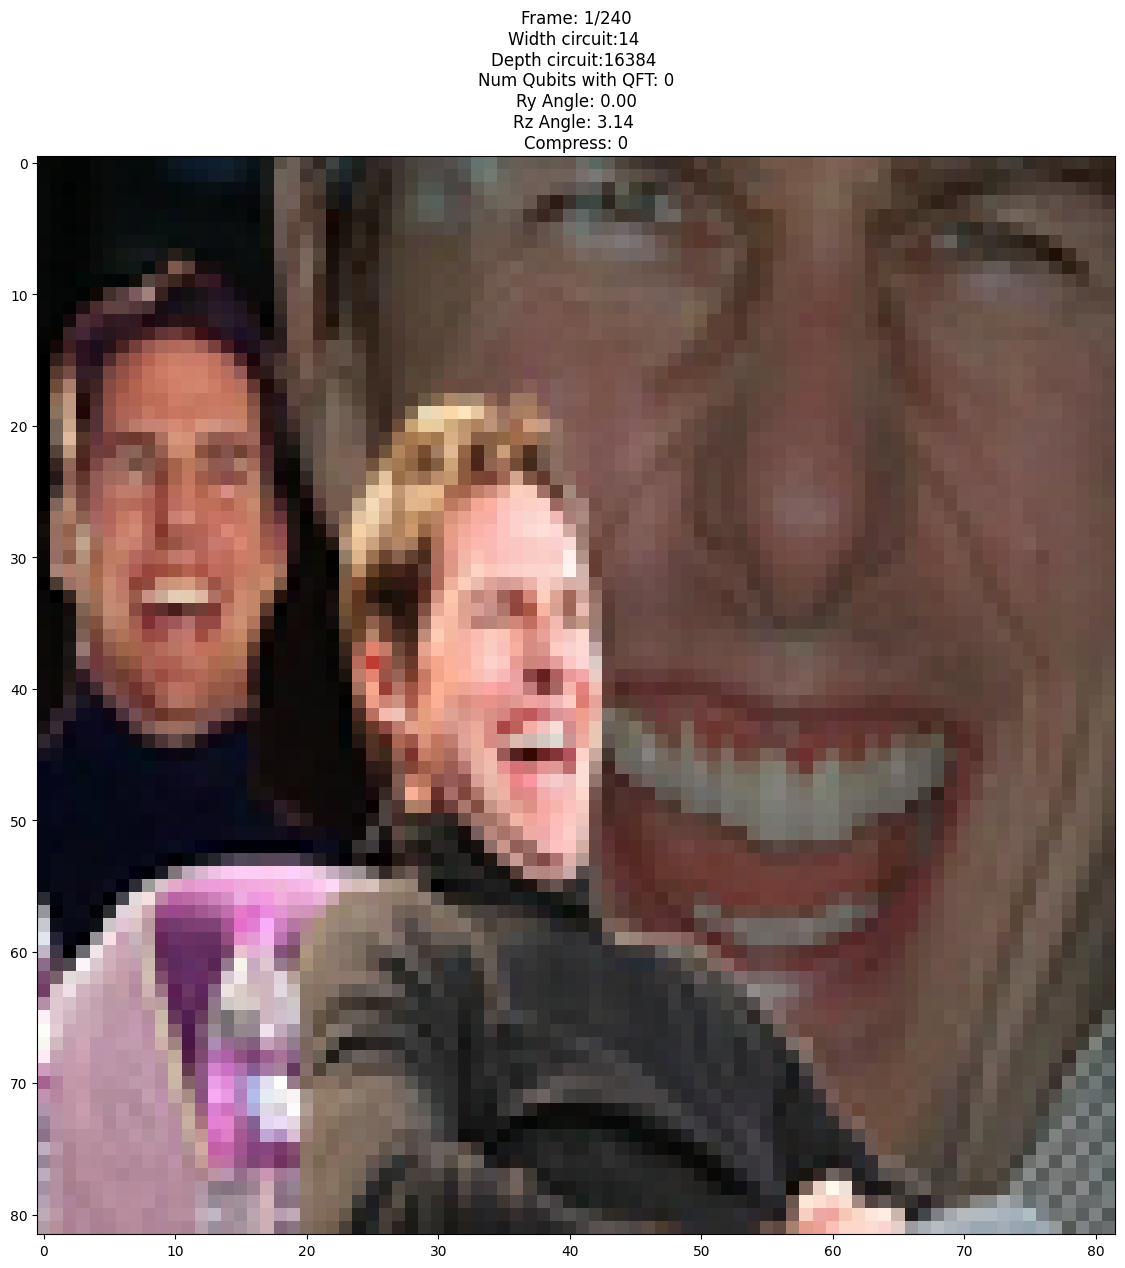

In [6]:

def plot_animation_frame_tom(frame_index):
    """
    Generates a single frame for the GIF animation, mapping the frame_index
    to the specified parameter ranges for ang1_num_qubits, ang2_ry, ang3_rz, and compress.
    """

    # --- Define Parameter Ranges ---
    # These define how each parameter sweeps over the animation duration
    num_qubits_range = (0, 7) 
    ang2_ry_range = (0, 2 * np.pi)
    ang3_rz_range = (0, 2 * np.pi)
    compress_range = (0, 60)

    total_frames = 240 # Total frames for the animation. Adjust for desired length.

    # --- Map frame_index to each parameter's value ---
    # sweep num_qubits and compress linearly
    # and make ang2_ry, ang3_rz oscillate for visual interest.

    # num_qubits: This needs to be an integer. It will step through the range.
    # To get steps, we can use the frame_index to pick values from a pre-defined set,
    # or round a linear interpolation.
    num_qubits = round(num_qubits_range[0] + 
                            (num_qubits_range[1] - num_qubits_range[0]) * (frame_index / total_frames))
    # Ensure it's an integer within the range [0, 14]
    num_qubits = max(num_qubits_range[0], min(num_qubits, num_qubits_range[1]))
    
    # ang2_ry: Linear sweep
    ang2_ry = ang2_ry_range[0] + (ang2_ry_range[1] - ang2_ry_range[0]) * (frame_index / total_frames)

    # ang3_rz: Sinusoidal oscillation for more dynamic visual
    # Oscillates between start and end of its range
    ang3_rz = ang3_rz_range[0] + (ang3_rz_range[1] - ang3_rz_range[0]) * (0.5 + 0.5 * np.sin(frame_index / total_frames * 2 * np.pi))
    
    # compress: Linear sweep
    compress = int(compress_range[0] + (compress_range[1] - compress_range[0]) * (frame_index / total_frames))
    # Ensure compress is within its bounds
    compress = max(compress_range[0], min(compress, compress_range[1]))

    encoded_decoded = []
    
    # Iterate for each channel (R, G, B)
    for channel_data in chans_tom: # Iterate directly over chans
        tempi = hlp.pad_0(channel_data.T.flatten())
        maxval = np.max(tempi)
        minval = np.min(tempi)
        qc_tom = cFRQI(tempi, compress)
        
        new_qubits_count = int(num_qubits) # Use the animated `ang1_num_qubits`

        qft(qc_tom, new_qubits_count) # Apply QFT

        if new_qubits_count == 0:
            qft_inverse(qc_tom, new_qubits_count)
        else:
            # Apply Ry and Rz to the 'new_qubits_count' range of qubits
            # using ang2_ry and ang3_rz
            qc_tom.ry(ang2_ry, range(new_qubits_count))
            qc_tom.rz(ang3_rz, range(new_qubits_count))
            qft_inverse(qc_tom, new_qubits_count)

        job = backend.run(qc_tom)

        sv = np.real(job.result().get_statevector())
        img2 = hlp.decodeQPIXL(sv, minval, maxval, scaling=hlp.convertToGrayscaleOld)
        
        # Ensure reconstruction uses the correct image dimensions from Image_ghost_data
        reconstructed_img = hlp.reconstruct_img(img2, (image_data_tom.shape[0], image_data_tom.shape[1]))
        encoded_decoded.append(reconstructed_img)

    rgb = np.abs(np.dstack(encoded_decoded))
    
    # Clear the current axes to prevent previous frames from overlapping
    plt.clf() 
    plt.imshow(Image.fromarray(np.array(rgb).astype(np.uint8), "RGB"))
    
    # Update title to show current parameter values
    plt.title(
        f"Frame: {frame_index+1}/{total_frames}\n"
        f"Width circuit:{qc_tom.width()} \n"
        f"Depth circuit:{qc_tom.depth()} \n"
        f"Num Qubits with QFT: {num_qubits}\n"
        f"Ry Angle: {ang2_ry:.2f}\n"
        f"Rz Angle: {ang3_rz:.2f} \n"
        f"Compress: {compress}"
    )


# --- Setup the figure and animation ---
fig = plt.figure(figsize=(14, 14)) # Adjust figure size as needed
ani = animation.FuncAnimation(fig, plot_animation_frame_tom, interval=30, frames=240) # 30ms interval = ~33 fps

# Save the animation as a GIF
writergif = animation.PillowWriter(fps=30) # Output GIF frames per second
ani.save("quantum_qft_animation_linear_rz_oscillate_240_frames_version.gif", writer=writergif)


print("GIF created successfully!")

## Dog Vs QFT 

In [7]:
chans2, image_data2 = get_rgb_channels("figures/pitbull_scared.jpg", target_shape=(82, 82))

In [8]:
def plot_interactive_rot(num_qubits, ang2_ry, ang3_rz, compress):
    encoded_decoded = []
  
    for i in chans2:
    
        tempi = hlp.pad_0(i.T.flatten())
        maxval = np.max(tempi)
        minval = np.min(tempi)
        qc2 = cFRQI(tempi, compress)
      
        new = int(num_qubits)
        qft(qc2, new)

        if new ==0:
            qft_inverse(qc2, new)
        else:
            qc2.ry(ang2_ry, range(new))
            qc2.rz(ang3_rz, range(new))
            qft_inverse(qc2, new)

    
        job = backend.run(qc2)
        
        sv = np.real(job.result().get_statevector())
        img2 = hlp.decodeQPIXL(sv, minval, maxval, scaling=hlp.convertToGrayscaleOld)
        encoded_decoded.append(
            hlp.reconstruct_img(img2, (len(image_data2), len(image_data2[0])))
        )

    print("Width circuit", qc2.width())
    print('Depth circuit', qc2.depth())
    rgb = np.abs(np.dstack(encoded_decoded))

    plt.imshow(Image.fromarray(np.array(rgb).astype(np.uint8), "RGB"))


interact(
    plot_interactive_rot,
    num_qubits=(0, 14, 1),
    ang2_ry=(0, 2 * np.pi, 0.1),
    ang3_rz=(0, 2 * np.pi, 0.1),
    compress=(0, 100, 5),
)

interactive(children=(IntSlider(value=7, description='num_qubits', max=14), FloatSlider(value=3.1, description…

<function __main__.plot_interactive_rot(num_qubits, ang2_ry, ang3_rz, compress)>

GIF 'quantum_animation_swept_params.gif' created successfully!


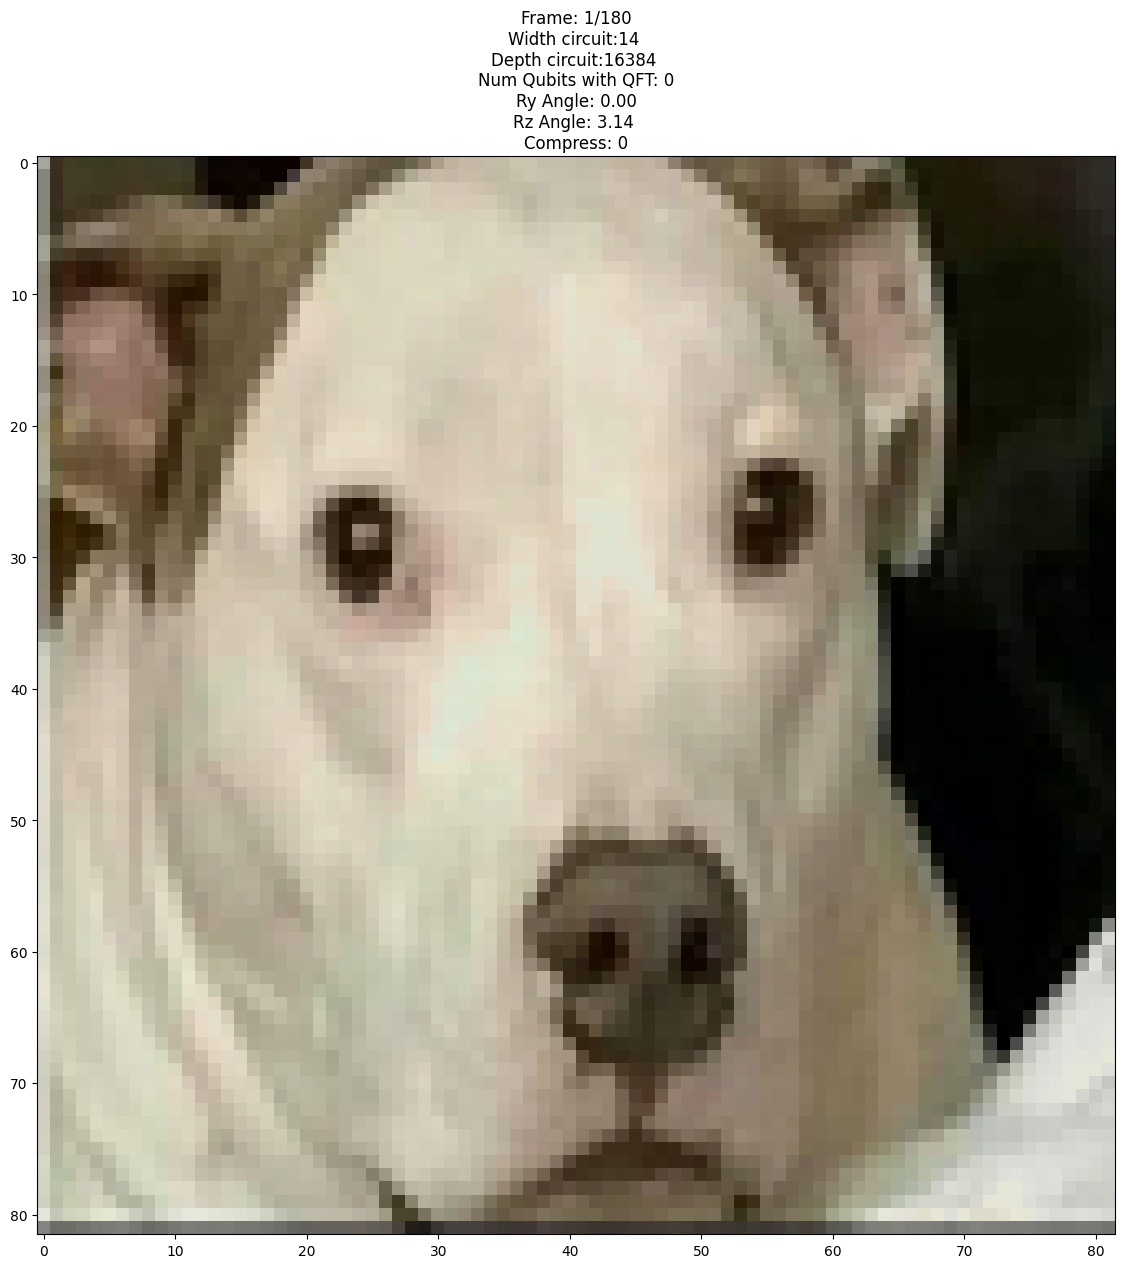

In [ ]:
def plot_animation_frame(frame_index):
    """
    Generates a single frame for the GIF animation, mapping the frame_index
    to the specified parameter ranges for num_qubits, ang2_ry, ang3_rz, and compress.
    """

    # --- Define Parameter Ranges ---
    # These define how each parameter sweeps over the animation duration
    num_qubits_range = (0, 6) 
    ang2_ry_range = (0, 2 * np.pi)
    ang3_rz_range = (0, 2 * np.pi)
    compress_range = (0, 60)

    total_frames = 240 # Total frames for the animation. Adjust for desired length.

    # --- Map frame_index to each parameter's value ---
    # We'll sweep num_qubits, ang2_ry, and compress linearly
    # and make ang3_rz oscillate for visual interest.

    # ang1_num_qubits: This needs to be an integer. It will step through the range.
    # To get steps, we can use the frame_index to pick values from a pre-defined set,
    # or round a linear interpolation
    num_qubits = round(num_qubits_range[0] + 
                            (num_qubits_range[1] - num_qubits_range[0]) * (frame_index / total_frames))
    # Ensure it's an integer within the range [0, 6]
    num_qubits = max(num_qubits_range[0], min(num_qubits, num_qubits_range[1]))
    
    # ang2_ry: Linear sweep
    ang2_ry = ang2_ry_range[0] + (ang2_ry_range[1] - ang2_ry_range[0]) * (frame_index / total_frames)

    # ang3_rz: Sinusoidal oscillation for more dynamic visual
    # Oscillates between start and end of its range
    ang3_rz = ang3_rz_range[0] + (ang3_rz_range[1] - ang3_rz_range[0]) * (0.5 + 0.5 * np.sin(frame_index / total_frames * 2 * np.pi))
    
    # compress: Linear sweep
    compress = int(compress_range[0] + (compress_range[1] - compress_range[0]) * (frame_index / total_frames))
    # Ensure compress is within its bounds
    compress = max(compress_range[0], min(compress, compress_range[1]))

    encoded_decoded = []

    # Iterate for each channel (R, G, B)
    for channel_data in chans2: # Iterate directly over chans
        tempi = hlp.pad_0(channel_data.T.flatten())
        maxval = np.max(tempi)
        minval = np.min(tempi)
        qc3 = cFRQI(tempi, compress)
        
        new_qubits_count = int(num_qubits)

        qft(qc3, new_qubits_count) # Apply QFT

        if new_qubits_count == 0:
            qft_inverse(qc3, new_qubits_count)
        else:
            # Apply Ry and Rz to the 'new_qubits_count' range of qubits
            # using ang2_ry and ang3_rz
            qc3.ry(ang2_ry, range(new_qubits_count))
            qc3.rz(ang3_rz, range(new_qubits_count))
            qft_inverse(qc3, new_qubits_count)

        job = backend.run(qc3)

        sv = np.real(job.result().get_statevector())
        img2 = hlp.decodeQPIXL(sv, minval, maxval, scaling=hlp.convertToGrayscaleOld)
        
        # Ensure reconstruction uses the correct image dimensions from Image
        reconstructed_img = hlp.reconstruct_img(img2, (image_data2.shape[0], image_data2.shape[1]))
        encoded_decoded.append(reconstructed_img)

    rgb = np.abs(np.dstack(encoded_decoded))
    
    # Clear the current axes to prevent previous frames from overlapping
    plt.clf() 
    plt.imshow(Image.fromarray(np.array(rgb).astype(np.uint8), "RGB"))
    
    # Update title to show current parameter values
    plt.title(
        f"Frame: {frame_index+1}/{total_frames}\n"
        f"Width circuit:{qc3.width()} \n"
        f"Depth circuit:{qc3.depth()} \n"
        f"Num Qubits with QFT: {num_qubits}\n"
        f"Ry Angle: {ang2_ry:.2f}\n"
        f"Rz Angle: {ang3_rz:.2f} \n"
        f"Compress: {compress}"
    )


# --- Setup the figure and animation ---
fig = plt.figure(figsize=(14, 14)) # Adjust figure size 
ani = animation.FuncAnimation(fig, plot_animation_frame, interval=30, frames=240) # 30ms interval = ~33 fps

# Save the animation as a GIF
writergif = animation.PillowWriter(fps=30) # Output GIF frames per second
ani.save("quantum_qft_animation_dog_240_framesversion.gif", writer=writergif)


print("GIF created successfully!")